Answer all questions and submit them either as an IPython notebook, LaTeX document, or Markdown document. Each question is worth 25 points.

This homework is due Tuesday, October 24, 2017.

In [2]:
%matplotlib inline
import numpy as np
#import pymc as pm
import pylab as plt
import pandas as pd

# Set seed
np.random.seed(10011)

# Question 1

Epidemiologists are interested in studying the sexual behavior of individuals at risk for HIV infection. Suppose 1500 gay men were surveyed and each was asked how many risky sexual encounters he had in the previous 30 days. Let $n_i$ denote the number of respondents reporting $i$ encounters, for $i = 1, \ldots , 16$. The DataFrame below contains these reponses:

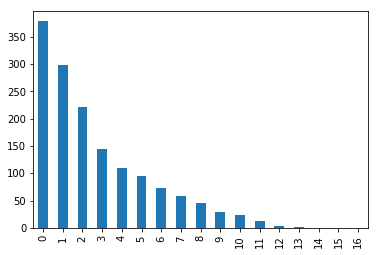

In [3]:
encounters = pd.DataFrame({'count': np.arange(17),
                          'freq': [379, 299, 222, 145, 109, 95, 73, 59,
                                  45, 30, 24, 12, 4, 2, 0, 1, 1]})

encounters.freq.plot.bar()

These data are poorly fitted by a Poisson model. It is more realistic to assume that the respondents comprise three groups. First, there is a group of people who, for whatever reason, report zero risky encounters even if this is not true. Suppose a respondent has probability $\alpha$ of belonging to this group. 

With probability $\beta$, a respondent belongs to a second group representing typical behavior. Such people respond truthfully, and their numbers of risky encounters are assumed to follow a $\text{Poisson}(\mu)$ distribution. 

Finally, with probability $1 − \alpha − \beta$, a respondent belongs to a high-risk group. Such people respond truthfully, and their numbers of risky encounters are assumed to follow a $\text{Poisson}(\lambda)$ distribution. 

The parameters in the model are $\alpha, \beta, \mu$ and $\lambda$. At the tth iteration of EM, we use $\theta^{(t)} = (\alpha^{(t)}, \beta^{(t)}, \mu^{(t)}, \lambda^{(t)})$ to denote the current parameter values. The likelihood of the observed data is given by:

$$L(\theta | n_0, \ldots, n_16) \propto \prod_{i=0}^{16} \left[ \frac{\pi_i(\theta)}{i!} \right]^{n_i}$$

where $\pi_i(\theta) = \alpha 1_{(i=0)} + \beta \mu^i \exp(-\mu) + (1-\alpha - \beta) \lambda^i \exp(-\lambda)$.

The observed data are in the `encounters` table above; the *complete* data may be construed to be $(n_{z,0}, n_{t,0}, n_{p,0}), \ldots, (n_{z,16}, n_{t,16}, n_{p,16})$, where $k = z, t, p$ correspond to zero, typical and promiscuous groups, respectively. That is, $n_0 = n_{z,0} + n_{t,0} + n_{p,0}$, and so on. Let $N = \sum_{i=0}^{16} n_i = 1500$.

Also define:

$$\begin{align}
z_0(\theta) &=& \frac{\alpha}{\pi_0(\theta)} \\
t_i(\theta) &=& \frac{\beta \mu^i \exp(-\mu)}{\pi_i(\theta)} \\
p_i(\theta) &=& \frac{(1-\alpha-\beta)\lambda^i \exp(-\lambda)}{\pi_i(\theta)}
\end{align}$$

which correspond to probabilities that respondents with $i$ risky encounters belong to various groups.

a. Show that the EM algorithm provides the following updates:

$$\begin{align}
\alpha^{(t+1)} &=& \frac{n_0 z_0(\theta^{(t)})}{N} \\
\beta^{(t+1)} &=& \sum_i \frac{n_i t_i(\theta^{(t)})}{N} \\
\mu^{(t+1)} &=& \frac{\sum_i i n_i t_i(\theta^{(t)})}{\sum_i n_i t_i(\theta^{(t)})} \\
\lambda^{(t+1)} &=& \frac{\sum_i i n_i p_i(\theta^{(t)})}{\sum_i n_i p_i(\theta^{(t)})}
\end{align}$$


b. Extimate the parameters of the model using the observed data.

In [3]:
# Write your answer here

In [ ]:
from scipy.stats.distributions import poisson


def e_step(alpha,beta,mu,lam):
    t=[]
    p=[]
    
    for i in range(0,16+1):
        pi=alpha*(i==0)+beta*np.exp(-mu)*(mu**i) +(1-alpha-beta)*(lam**i)*np.exp(-lam)
        z= alpha/pi*(i==0)
        ti=beta*(mu**i)*np.exp(-mu)/pi
        t.append(ti)
        
        pt=(1-alpha-beta)*(lam**i)*np.exp(-lam)/pi
        p.append(pt)
    
    return z,t,p


In [26]:
a,b,c=e_step(1,2,3,4)

In [15]:
a

-0.0

In [18]:
len(b)

17

In [27]:
n=np.array([379, 299, 222, 145, 109, 95, 73, 59,45, 30, 24, 12, 4, 2, 0, 1, 1])

In [22]:
type(n)

list

In [28]:
b=np.array(b)

In [ ]:
print(np.sum(n*b))

In [ ]:
def m_step(z,t,p,n,N=1500):
    #n is a vector of n0,n1,...,n16
    # w is the combination of z,t,p from e step
    
    
    t=np.array(t)
    p=np.array(p)
    
    alpha= n[0]*z/N
    beta=np.sum(n*t/N)
    
    tsum=0
    for i in range(0,16+1):
        tsum=tsum+i*n[i]*t[i]
        
    mu=tsum/np.sum(n*t)
    
    psum=0
    for i in range(0,16+1):
        psum=psum+i*p[i]*n[i]
    
    lam=psum/np.sum(n*t)
    
    return alpha,beta,mu,lam


In [35]:
m_step(a,b,c)

(-0.0, 0.94747634992871843, 0.56861375574705153, 2.2789507245726726)

In [ ]:
resp=np.array([379, 299, 222, 145, 109, 95, 73, 59,45, 30, 24, 12, 4, 2, 0, 1, 1]) #data
    

def run_em(alpha0=0.2, beta0=0.5,mu0=5,lam0=5, n=resp):
    
    # Initialize values
    alpha=alpha0
    beta=beta0
    mu=mu0
    lam=lam0

    # Stopping criterion
    crit = 1e-3

    # Convergence flag
    converged = False

    # Loop until converged
    while not converged:

        # E-step
        z,t,p = e_step(alpha,beta,mu,lam)
        # M-step
        alpha_new, beta_new,mu_new,lam_new = m_step(z,t,p,n)

        # Check convergence
        converged = ( np.all(np.abs((np.array(alpha_new) - np.array(alpha)) < crit)) 
                     & np.all(np.abs((np.array(mu_new) - np.array(mu)) < crit))
                     & np.all(np.abs((np.array(beta_new) - np.array(beta)) < crit))
                     & np.all(np.abs((np.array(lam_new) - np.array(lam)) < crit)) ) 
                
        alpha, beta, mu, lam = alpha_new, beta_new,mu_new,lam_new

    return  alpha, beta, mu, lam

In [ ]:
run_em()

In [5]:
(1==0)*2

0

In [7]:
list(range(0,17))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

# Question 2

Suppose $y$ has a binomial distribution with parameters $n$ and $p$, and we are interested in the log-odds value $\theta = \log(p/(1 − p))$. Our prior for $\theta$ is that $\theta \sim N(\mu, \sigma^2)$. It follows that the posterior density of $\theta$ is given, up to a proportionality constant, by:

$$\pi(\theta | y) \propto \frac{\exp(y\theta)}{(1 + exp(\theta))^n} \exp\left[\frac{-(\theta − \mu)^2}{2\sigma^2}\right]$$

For example, suppose we are interested in learning about the probability that a possibly-biased coin lands heads when tossed. *A priori* we believe that the coin is fair, so we assign $\theta$ a $N(0,.25)$ prior. We toss the coin $n = 5$ times and obtain $y = 5$ heads.

1. Using a normal approximation to the posterior density, compute the probability that the coin is biased toward heads (i.e., that θ is positive).
2. Using the prior density as a proposal density, design a rejection algorithm for sampling from the posterior distribution. Using simulated draws from your algorithm, approximate the probability that the coin is biased toward heads.
3. Using the prior density as a proposal density, simulate values from the posterior distribution using the SIR algorithm. Approximate the probability that the coin is biased toward heads.

In [4]:
# Write your anser here
#1. normal approximation
import scipy as sp
import scipy.stats as stats

binom=stats.binom
norm=stats.norm

theta=norm(0,0.5).rvs(1)
y=5
n=5
post=(np.exp(y*theta)/((1+np.exp(theta))**n) )*np.exp(-(theta**2)/(2*0.25))



# Question 3

The goal of this problem is to investigate the role of the proposal distribution in a Metropolis-Hastings algorithm designed to simulate from the posterior distribution of the mixture parameter $\delta$. 

1. Simulate 200 realizations from the mixture distribution:
    $$y_i \sim \delta N(7, 0.5^2) + (1-\delta) N(10, 0.5^2)$$
    with $\delta = 0.7$. Plot a histogram of these data. 
2. Implement a random walk M-H algorithm with proposal $\delta^{\prime} = \delta^{(i)} + \epsilon$ with $\epsilon \sim Unif(−1,1)$. 
3. Reparameterize the problem letting $U = \log\left[\frac{\delta}{1 - \delta}\right]$ and $u^{\prime} = u^{(i)} + \epsilon$. Implement a random walk chain in U-space. 
4. Compare the estimates and convergence behavior of the three algorithms.

In part (1), you are asked to simulate data from a distribution with $\delta$ known. For parts (2)–(3), assume $\delta$ is unknown with prior $\delta \sim Unif( 0,1)$. For parts (2)–(3), provide an appropriate plot and a table summarizing the output of the algorithm. 

To facilitate comparisons, use the same number of iterations, random seed, starting values, and burn-in period for all implementations of the algorithm. 

In [5]:
# Write answer here

# Question 4

Carlin (1992) considers a Bayesian approach to meta-analysis, and includes the following examples of 22 trials of beta-blockers to prevent mortality after myocardial infarction. These data are given below.

In one possible random effects model we assume the true baseline mean (on a log-odds scale) $m_i$ in a trial $i$
is drawn from some population distribution. Let $r^C_i$ denote number of events in the control group in trial $i$, and $r^T_i$ denote events under active treatment in trial $i$. Our model is:

$$\begin{aligned}
r^C_i &\sim \text{Binomial}\left(p^C_i, n^C_i\right) \\
r^T_i &\sim \text{Binomial}\left(p^T_i, n^T_i\right) \\
\text{logit}\left(p^C_i\right) &= \mu_i \\
\text{logit}\left(p^T_i\right) &= \mu_i + \delta \\
\mu_i &\sim \text{Normal}(m, s).
\end{aligned}$$

In this case, we want to make inferences about the population effect $m$, and the predictive distribution for the effect $\delta_{\text{new}}$ in a new trial. 

This particular model uses a random effect for the population mean, and a fixed effect for the treatment effect. There are 3 other models you could fit to represent all possible combinations of fixed or random effects for these two parameters.

Build all 4 models to estimate the treatment effect in PyMC3 and 

1. use convergence diagnostics to check for convergence in each model 
2. use posterior predictive checks to compare the fit of the models
3. use DIC to compare the models as approximations of the true generating model

Which model would you select and why?

In [6]:
r_t_obs = [3, 7, 5, 102, 28, 4, 98, 60, 25, 138, 64, 45, 9, 57, 25, 33, 28, 8, 6, 32, 27, 22]
n_t_obs = [38, 114, 69, 1533, 355, 59, 945, 632, 278,1916, 873, 263, 291, 858, 154, 207, 251, 151, 174, 209, 391, 680]
r_c_obs = [3, 14, 11, 127, 27, 6, 152, 48, 37, 188, 52, 47, 16, 45, 31, 38, 12, 6, 3, 40, 43, 39]
n_c_obs = [39, 116, 93, 1520, 365, 52, 939, 471, 282, 1921, 583, 266, 293, 883, 147, 213, 122, 154, 134, 218, 364, 674]
N = len(n_c_obs)

In [7]:
# Write answer here